In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.xception import Xception
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from IPython.display import Image, display
import matplotlib.cm as cm
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
classifier_model = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/Deep Learning - Final Project/Main model for localization/classifier")

In [ ]:
classifier_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_1 (ModuleWrap (None, 2048)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 6147      
Total params: 6,147
Trainable params: 6,147
Non-trainable params: 0
_________________________________________________________________


In [ ]:
convbase = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/Deep Learning - Final Project/Main model for localization/conv_base")

In [ ]:
convbase.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [ ]:
x = convbase.output
x = reconstructed_model.layers[1](x)
x = reconstructed_model.layers[2](x)
x = reconstructed_model.layers[3](x)

model = keras.Model(convbase.input , x)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [ ]:
model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [ ]:
def get_img_array(img_path, size):
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    array = keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

In [ ]:

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):

    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )


    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))


    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = cm.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    heatmap_img = keras.preprocessing.image.array_to_img(jet_heatmap * alpha)
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)

    display(Image(cam_path))

    return heatmap_img

In [ ]:
def display_gradcam(image_path, last_conv_layer_name):
    img_array = get_img_array(img_path, size=image_size) / 255.

    preds = model.predict(img_array)
    print("Predicted:", preds)

    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    plt.matshow(heatmap)
    plt.show()

    superimposed_img = save_and_display_gradcam(img_path, heatmap)

    return superimposed_img

In [ ]:
selected_conv = [
  "block14_sepconv2_act",
]
last_conv_layer_name = 'block14_sepconv2_act'

In [ ]:
image_size = (300, 300)

In [ ]:
def display_gradcam_multiple(img_path, selected_conv):
  for i in selected_conv:
      
    img_array = get_img_array(img_path, size=image_size) / 255.

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(img_array, model, i)
    print(heatmap)
    # Display heatmap
    plt.matshow(heatmap)
    plt.show()

    save_and_display_gradcam(img_path, heatmap)

In [ ]:
class DrawContours:
    def __init__(self):
        self.bbox = []
    
    def set_image(self, image, original_image):
        self.img = np.array(image)
        # cv2.imread(image, cv2.CV_8UC1)
        self.new_image = self.img.copy()
        self.original_image = original_image

    def convert_to_gray(self):

        self.grey_2 = np.array(heatmap_image) / 255.

        for i in range(self.grey_2.shape[0]):
            for j in range(self.grey_2.shape[1]):
                # if (a[i, j][0] > 0.1 and a[i, j][1] > 0.1) or (a[i, j][1] > 0.1 and a[i, j][2] > 1):
                # if (self.grey_2[i, j][0] > 0.1 and self.grey_2[i, j][1] > 0.1) or (self.grey_2[i, j][1] > 0.1 and self.grey_2[i, j][2] > 1):
                # if self.grey_2[i, j][0] > 0.0 and self.grey_2[i, j][1] > 0.02 and self.grey_2[i, j][2] < 0.65:
                if (self.grey_2[i, j][0] > 0.1 and self.grey_2[i, j][1] > 0.1 and self.grey_2[i, j][2] < 0.7) or (self.grey_2[i, j][0] < 1 and self.grey_2[i, j][1] < 0.6 and self.grey_2[i, j][2] < 0.3):
                # if (self.grey_2[i, j][0] > 0.01 and self.grey_2[i, j][2] < 0.55) or (self.grey_2[i, j][1] > 0.01 and self.grey_2[i, j][2] < 0.55):
                    self.grey_2[i, j] = 1.0
                else:
                    self.grey_2[i, j] = 0.0

        self.grey_2 = self.grey_2.astype('uint8') * 255
        plt.imshow(self.grey_2)
        plt.show()       
        

    def convert_to_grayscale(self):        
        # Convert the image to grayscale
        self.gray = cv2.cvtColor(self.grey_2, cv2.COLOR_BGR2GRAY)
        

        # Display the grayscale image
        plt.imshow(self.gray)
        plt.show()
    
    def convert_grayscale_to_binary(self):
        # Convert the grayscale image to binary
        self.ret, self.binary = cv2.threshold(self.gray, 0, 255, cv2.THRESH_OTSU)
        # cv2.THRESH_TRIANGLE
        # cv2.THRESH_BINARY
        # cv2.THRESH_OTSU
        
        # Display the binary image
        plt.imshow(self.binary)
        plt.show()

    def invert_image(self):
        # To detect object contours, we want a black background and a white 
        # foreground, so we invert the image (i.e. 255 - pixel value)
        self.inverted_binary = self.binary
        plt.imshow(self.inverted_binary)
        plt.show()

    def find_contours(self):
        # Find the contours on the inverted binary image, and store them in a list
        # Contours are drawn around white blobs.
        # hierarchy variable contains info on the relationship between the contours
        self.contours, self.hierarchy = cv2.findContours(self.inverted_binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        
    def draw_contours(self, index=-1):
        # Draw the contours (in red) on the original image and display the result
        # Input color code is in BGR (blue, green, red) format
        # -1 means to draw all contours
        self.with_contours = cv2.drawContours(self.img, self.contours, index, (255,0,255), 3)
        plt.imshow(self.with_contours)
        plt.show()       
 
        # Show the total number of contours that were detected
        print('Total number of contours detected: ' + str(len(self.contours)))
    
    def draw_first_contours(self):
        # Draw just the first contour
        # The 0 means to draw the first contour
        self.first_contour = cv2.drawContours(self.new_image, self.contours, 0,(255,0,255),3)
        plt.imshow(self.first_contour)        

    def get_bboxes(self):
        for c in self.contours:
            x, y, w, h = cv2.boundingRect(c)
            
            if (cv2.contourArea(c)) > 10000:
                self.bbox.append(( x, y, w, h))
        return self.bbox

    def draw_bounding_box(self):
        # Draw a bounding box around the first contour
        # x is the starting x coordinate of the bounding box
        # y is the starting y coordinate of the bounding box
        # w is the width of the bounding box
        # h is the height of the bounding box
        x, y, w, h = cv2.boundingRect(self.contours[0])
        cv2.rectangle(self.first_contour,(x,y), (x+w,y+h), (255,0,0), 5)
        plt.imshow(self.first_contour)
        plt.show()
    
    def draw_all_contours(self):                
        # Draw a bounding box around all contours
        for c in self.contours:
            x, y, w, h = cv2.boundingRect(c)
            
            if (cv2.contourArea(c)) > 10000:
                cv2.rectangle(self.with_contours ,(x,y), (x+w,y+h), (255,0,0), 5)
                
        plt.imshow(self.with_contours)
        plt.show()
    
    def run(self):
        self.convert_to_gray()
        self.convert_to_grayscale()
        self.convert_grayscale_to_binary()
        self.invert_image()
        self.find_contours()
        self.draw_contours()
        self.draw_first_contours()
        self.draw_bounding_box()
        self.draw_all_contours()
    
    def crop_image(self):
        cropped_images = []
        for i in self.get_bboxes():
            x, y, w, h = i
            cropped_images.append(self.original_image[y:y+h, x:x+w])
        return cropped_images



32768/24630 [=======================================] - 0s 0us/step
Predicted: [[0.9604687  0.0540657  0.00851637]]


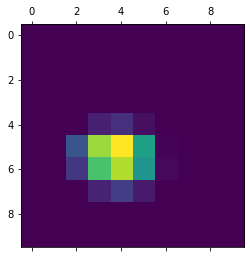

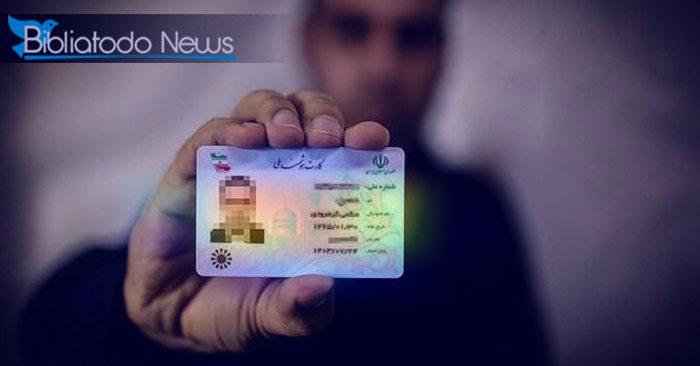

In [ ]:
img_path = keras.utils.get_file(
    "8754.jpg", "https://www.bibliatodo.com/En/christian-news/files/2020/02/Iran-forces-Christians-to-reveal-their-faith-to-obtain-national-identification-document.jpg"
)

original_image = keras.preprocessing.image.load_img(img_path)
original_image = keras.preprocessing.image.img_to_array(original_image) / 255.

heatmap_image = display_gradcam(img_path, last_conv_layer_name)

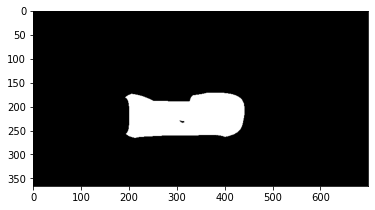

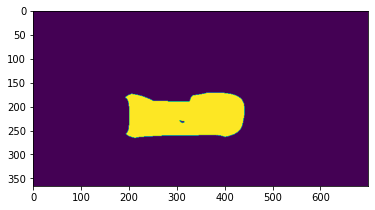

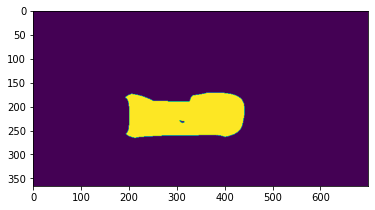

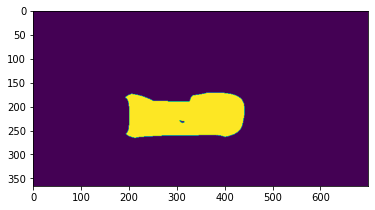

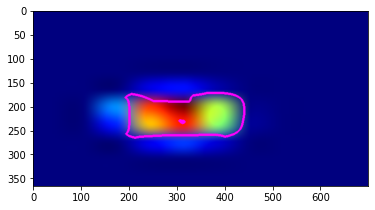

Total number of contours detected: 2


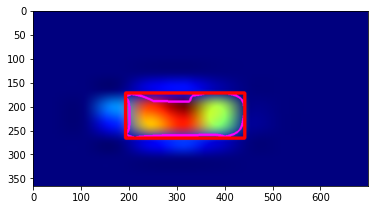

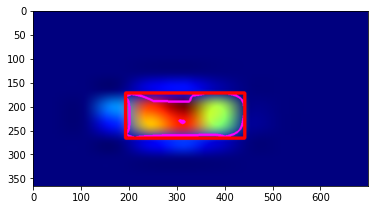

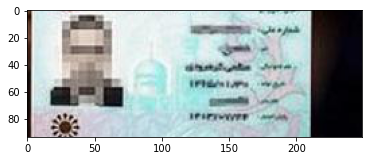

In [ ]:
ct_agent = DrawContours()
ct_agent.set_image(heatmap_image, original_image)
ct_agent.run()
id_cards = ct_agent.crop_image()
for i in id_cards:
    plt.imshow(i)
    plt.show()

32768/32526 [==============================] - 0s 1us/step
Predicted: [[9.9999923e-01 5.3395947e-06 2.1487168e-09]]


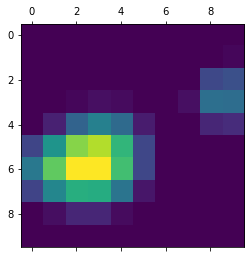

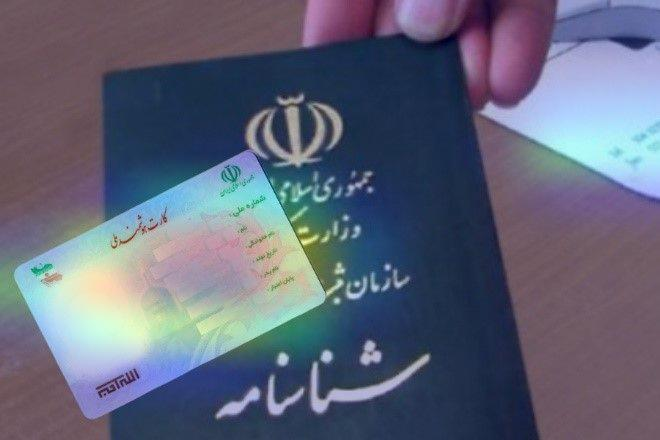

In [ ]:
img_path = keras.utils.get_file(
    "0546tyghddf.jpg", "https://i.ibb.co/jMRvnFF/317407-475.jpg"
)


original_image = keras.preprocessing.image.load_img(img_path)
original_image = keras.preprocessing.image.img_to_array(original_image) / 255.

heatmap_image = display_gradcam(img_path, last_conv_layer_name)

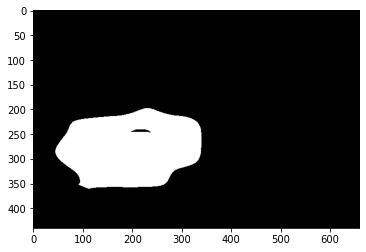

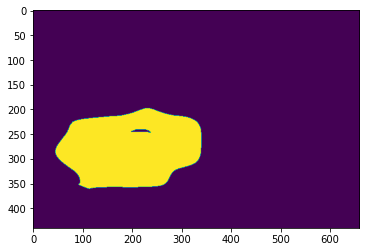

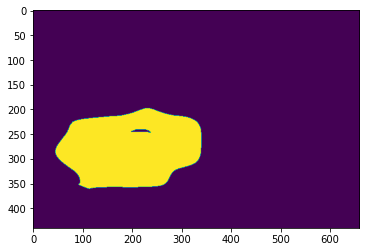

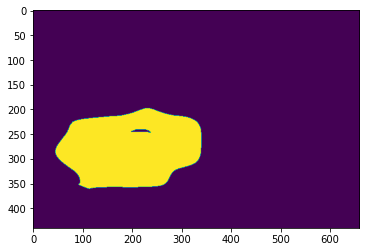

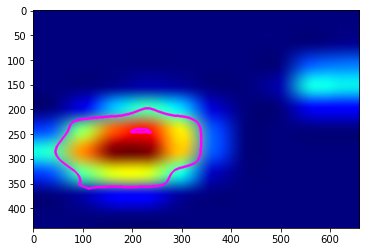

Total number of contours detected: 2


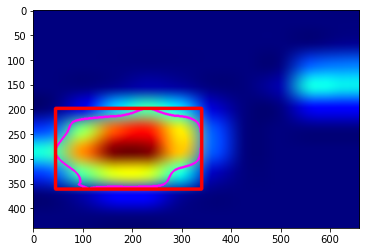

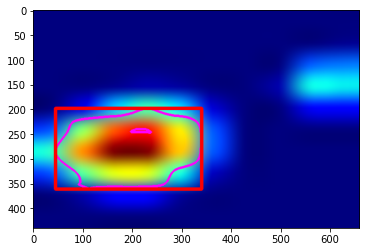

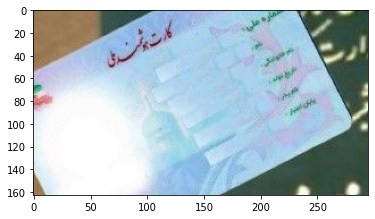

In [ ]:
ct_agent = DrawContours()
ct_agent.set_image(heatmap_image, original_image)
ct_agent.run()
id_cards = ct_agent.crop_image()
for i in id_cards:
    plt.imshow(i)
    plt.show()

Predicted: [[9.9997354e-01 6.3576284e-05 2.1169149e-06]]


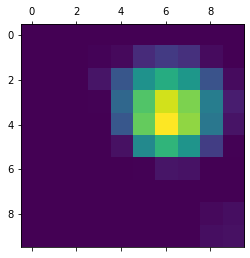

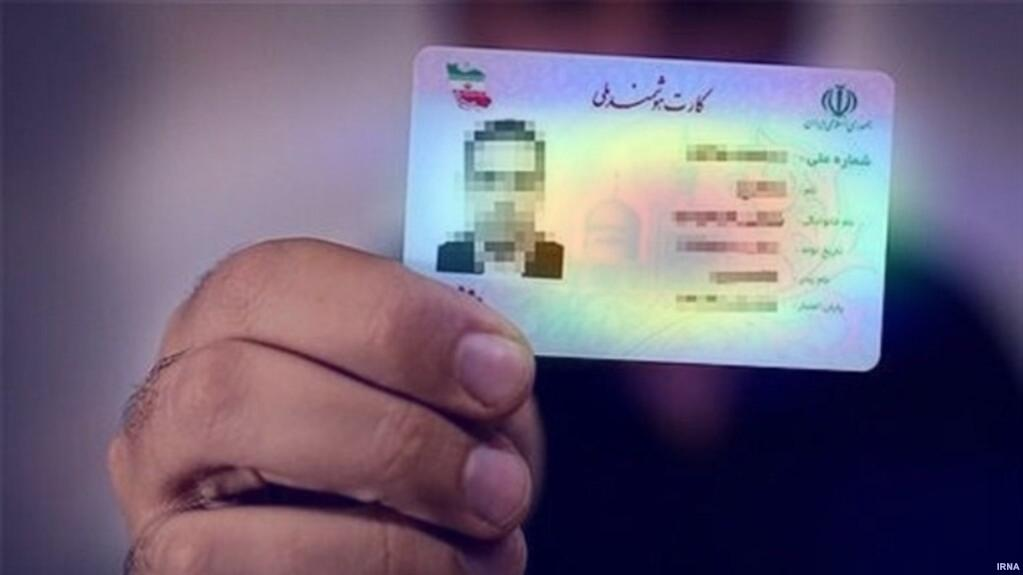

In [ ]:
img_path = keras.utils.get_file(
    "8754test.jpg", "https://gdb.rferl.org/EDFF2936-65DF-4E60-98D4-613A6DED7917_w1023_r1_s.jpg"
)

original_image = keras.preprocessing.image.load_img(img_path)
original_image = keras.preprocessing.image.img_to_array(original_image) / 255.

heatmap_image = display_gradcam(img_path, last_conv_layer_name)

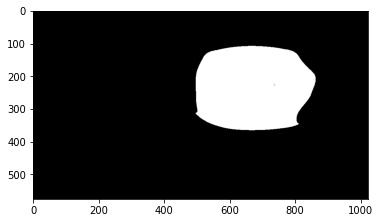

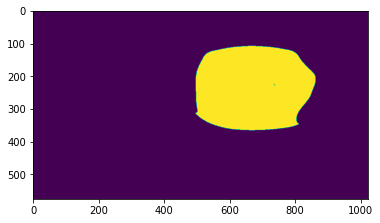

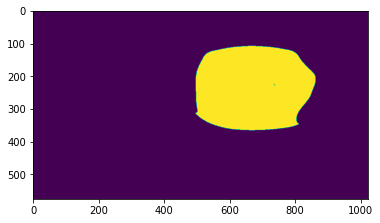

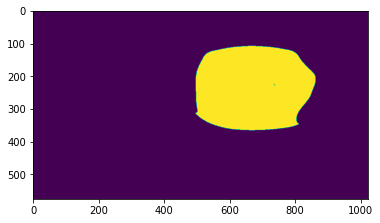

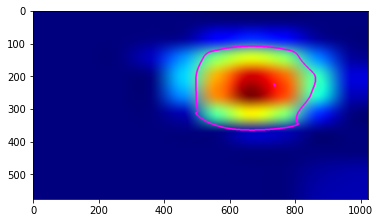

Total number of contours detected: 5


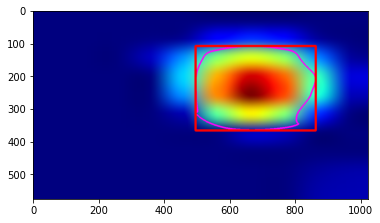

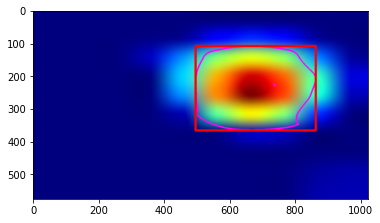

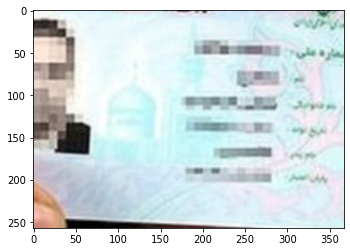

In [ ]:
ct_agent = DrawContours()
ct_agent.set_image(heatmap_image, original_image)
ct_agent.run()
id_cards = ct_agent.crop_image()
for i in id_cards:
    plt.imshow(i)
    plt.show()

Predicted: [[9.9983168e-01 4.0068328e-03 1.2895183e-11]]


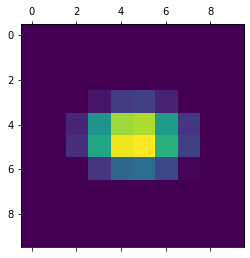

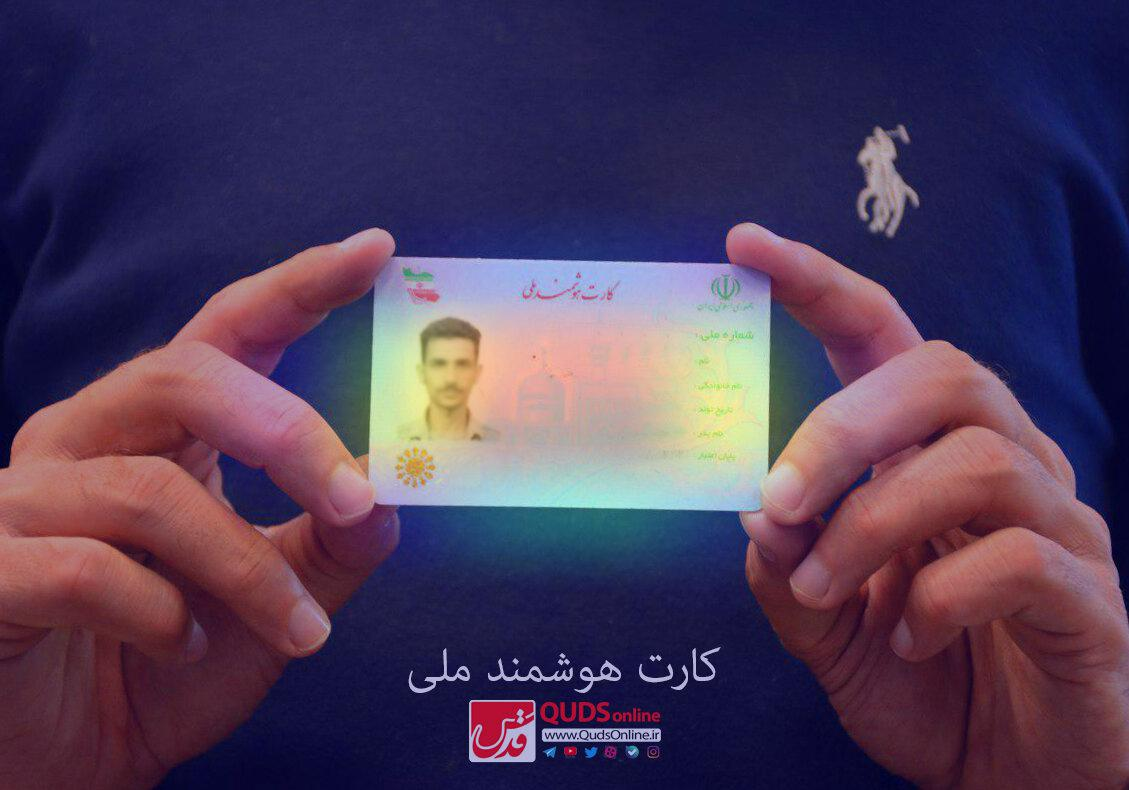

In [ ]:
img_path = keras.utils.get_file(
    "test035484.jpg", "https://i.ibb.co/n0Hdzgs/944103.jpg"
)

original_image = keras.preprocessing.image.load_img(img_path)
original_image = keras.preprocessing.image.img_to_array(original_image) / 255.

heatmap_image = display_gradcam(img_path, last_conv_layer_name)

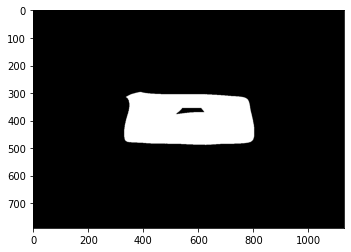

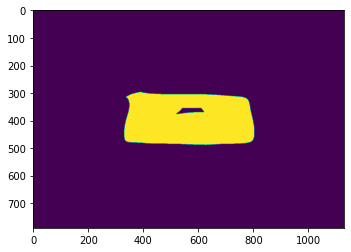

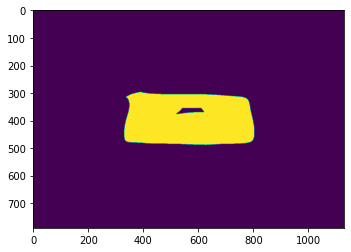

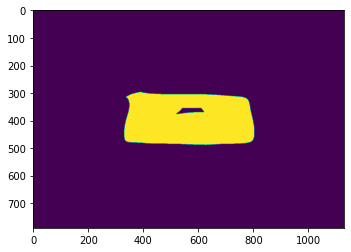

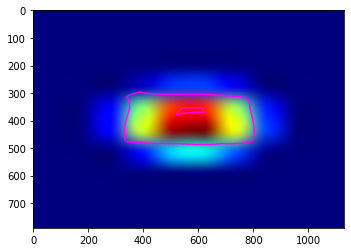

Total number of contours detected: 2


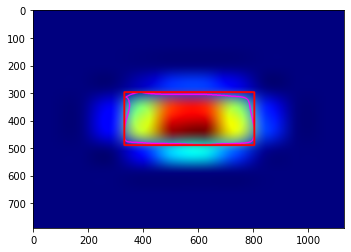

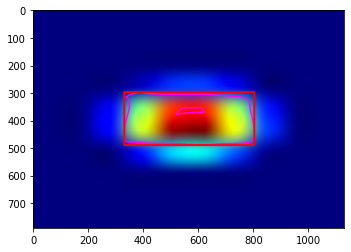

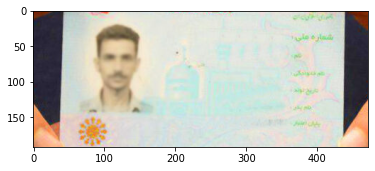

In [ ]:
ct_agent = DrawContours()
ct_agent.set_image(heatmap_image, original_image)
ct_agent.run()
id_cards = ct_agent.crop_image()
for i in id_cards:
    plt.imshow(i)
    plt.show()

Predicted: [[9.9999946e-01 1.2517140e-06 4.4832525e-08]]


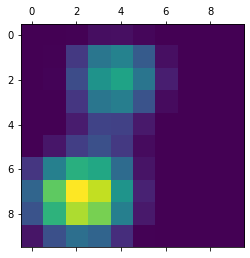

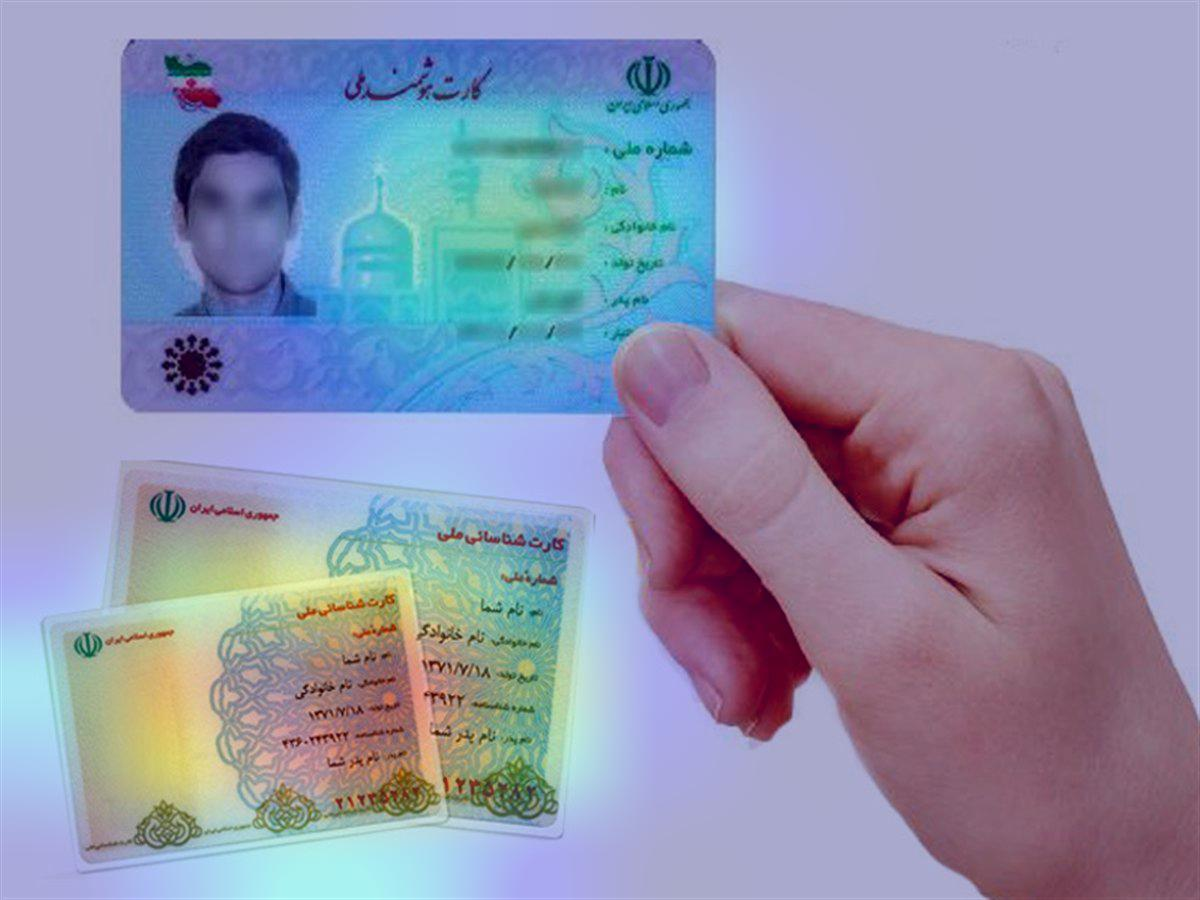

In [ ]:
img_path = keras.utils.get_file(
    "te8877.jpg", "https://i.ibb.co/0yx4ks4/image.jpg"
)

original_image = keras.preprocessing.image.load_img(img_path)
original_image = keras.preprocessing.image.img_to_array(original_image) / 255.

heatmap_image = display_gradcam(img_path, last_conv_layer_name)

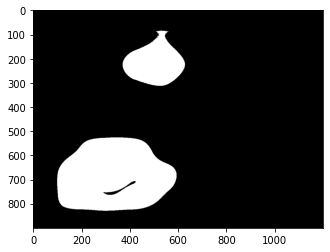

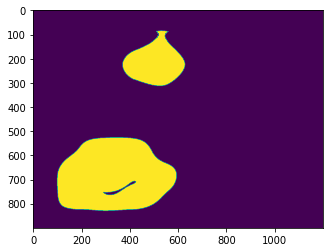

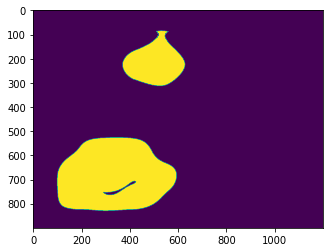

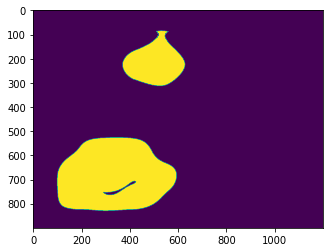

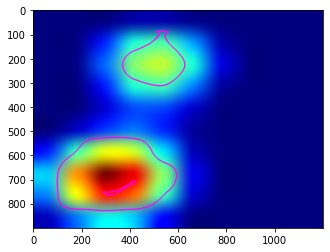

Total number of contours detected: 3


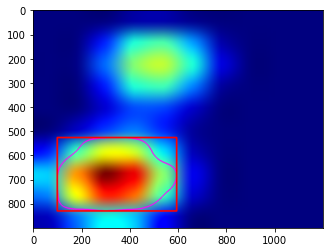

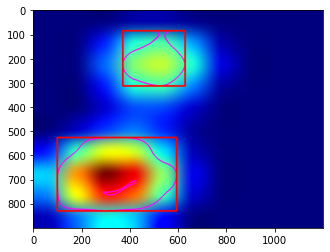

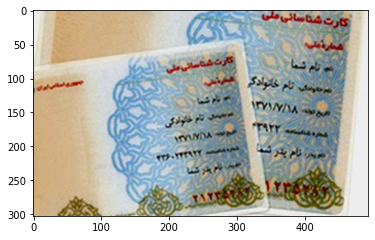

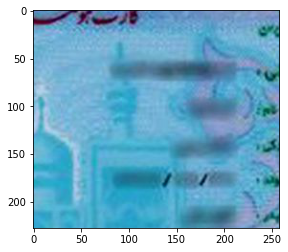

In [ ]:
ct_agent = DrawContours()
ct_agent.set_image(heatmap_image, original_image)
ct_agent.run()
id_cards = ct_agent.crop_image()
for i in id_cards:
    plt.imshow(i)
    plt.show()

57344/52868 [================================] - 0s 1us/step
Predicted: [[9.9970293e-01 7.9125166e-04 5.0385611e-06]]


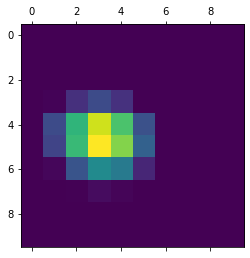

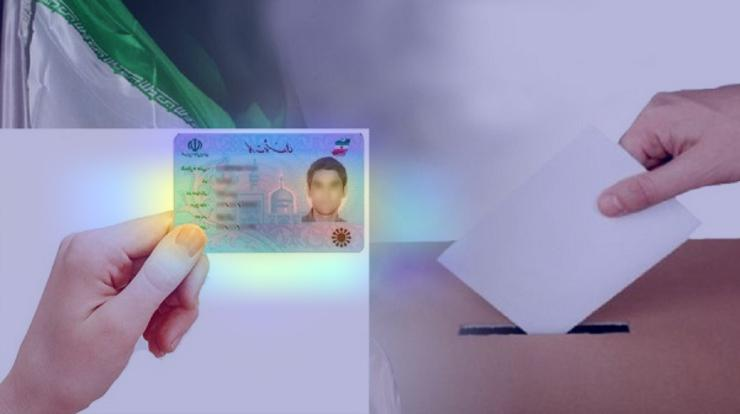

In [ ]:

img_path = keras.utils.get_file(
    "65542.jpg", "https://i.ibb.co/ZxCTdGB/65542-995.jpg"
)

original_image = keras.preprocessing.image.load_img(img_path)
original_image = keras.preprocessing.image.img_to_array(original_image) / 255.

heatmap_image = display_gradcam(img_path, last_conv_layer_name)

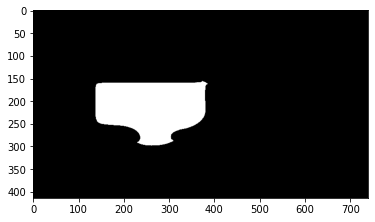

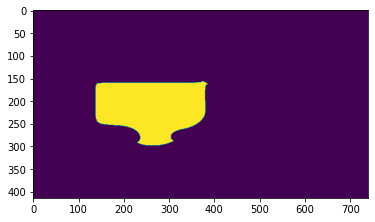

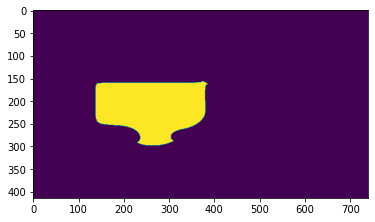

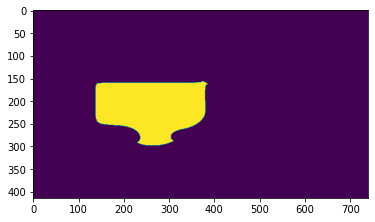

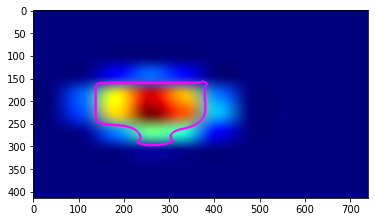

Total number of contours detected: 1


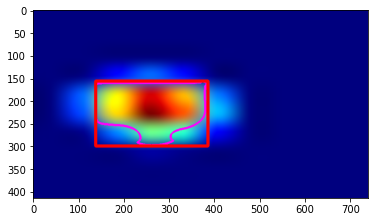

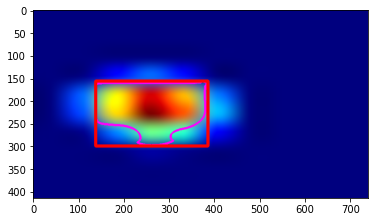

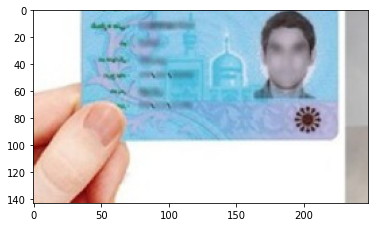

In [ ]:
ct_agent = DrawContours()
ct_agent.set_image(heatmap_image, original_image)
ct_agent.run()
id_cards = ct_agent.crop_image()
for i in id_cards:
    plt.imshow(i)
    plt.show()

147456/145283 [==============================] - 0s 0us/step
Predicted: [[9.9964988e-01 1.3496578e-03 1.4321045e-06]]


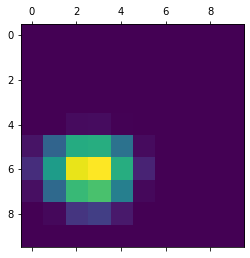

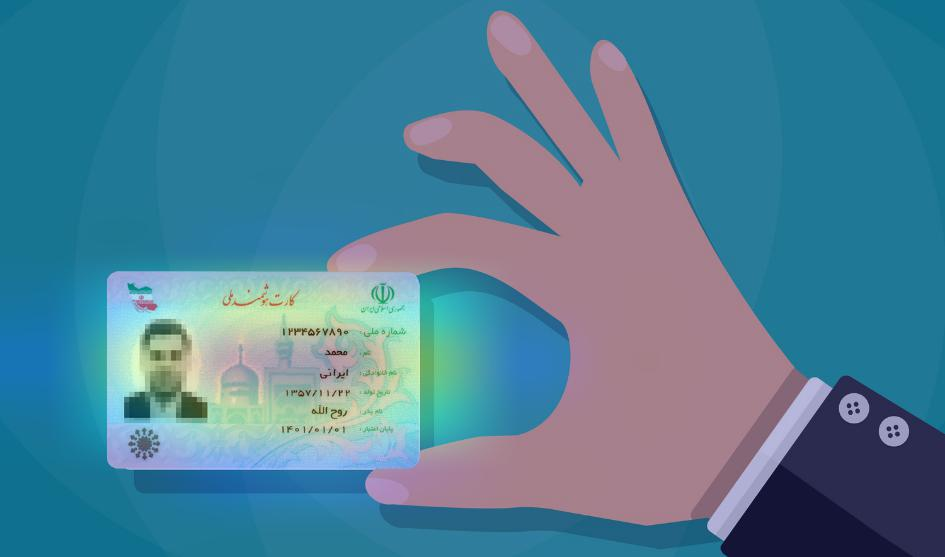

In [ ]:
img_path = keras.utils.get_file(
    "654545542.jpg", "https://i.ibb.co/y0j2jj8/61.jpg"
)

original_image = keras.preprocessing.image.load_img(img_path)
original_image = keras.preprocessing.image.img_to_array(original_image) / 255.

heatmap_image = display_gradcam(img_path, last_conv_layer_name)

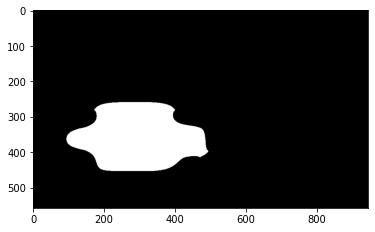

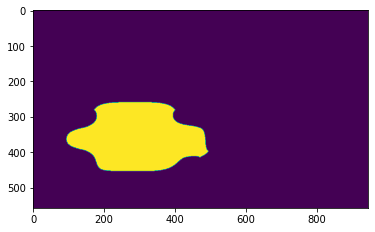

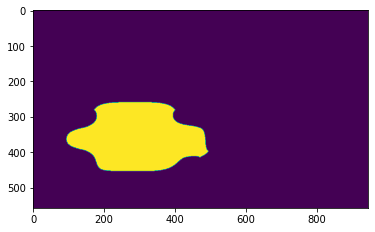

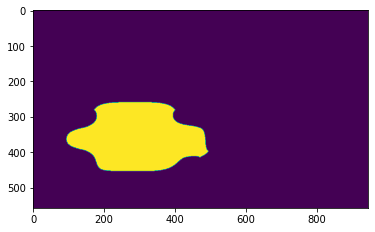

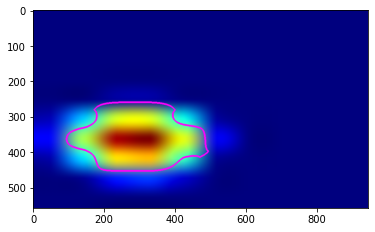

Total number of contours detected: 1


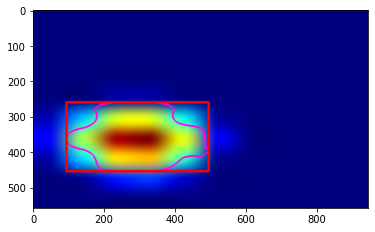

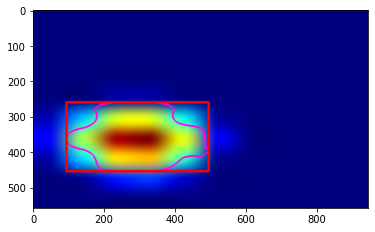

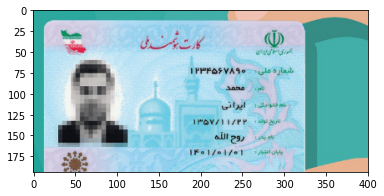

In [ ]:
ct_agent = DrawContours()
ct_agent.set_image(heatmap_image, original_image)
ct_agent.run()
id_cards = ct_agent.crop_image()
for i in id_cards:
    plt.imshow(i)
    plt.show()